In [22]:
import numpy as np
import pandas as pd
import zipfile as zp
from pathlib import Path
from gensim.utils import check_output
from sklearn.preprocessing import normalize
from scipy.special import softmax
import shutil
from subprocess import check_output
import torch
from tqdm import tqdm
import colored
import itertools
import matplotlib.pyplot as plt
from scipy.special import softmax
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
plt.rcParams.update({'font.size': 16})

In [23]:
def printgr(text):
    print(colored.stylize(text, colored.fg('green')))

In [24]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse

In [25]:
#cd /export/usuarios_ml4ds/lbartolome/topicmodeler

In [26]:
#from src.topicmodeling.neural_models.pytorchavitm.datasets.bow_dataset import BOWDataset
#from src.topicmodeling.neural_models.pytorchavitm.avitm_network.avitm import AVITM
#from src.topicmodeling.neural_models.pytorchavitm.utils.data_preparation import prepare_dataset

In [27]:
modelsdir = Path("/export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test")

In [28]:
!git clone https://github.com/MIND-Lab/OCTIS.git

fatal: destination path 'OCTIS' already exists and is not an empty directory.


In [29]:
cd OCTIS

/export/usuarios_ml4ds/lbartolome/topicmodeler/aux/federated/OCTIS/OCTIS


In [30]:
from octis.models.pytorchavitm.avitm import avitm_model as AVITM

In [31]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

#from octis.models.pytorchavitm.datasets.bow import BOWDataset

import torch
from torch.utils.data import Dataset


class BOWDataset(Dataset):
    
    """Class to load BOW dataset."""

    def __init__(self, X, idx2token):

        """
        Initializes BOWDataset.

        Parameters
        ----------
        X : array-like, shape=(n_samples, n_features)
            Document-term matrix
        idx2token : list
            A list of feature names
        """
        self.X = X
        self.idx2token = idx2token

    def __len__(self):
        """Returns length of dataset."""
        return len(self.X)

    def __getitem__(self, i):
        """Returns sample from dataset at index i."""
        X = torch.FloatTensor(self.X[i])

        return {'X': X}

def prepare_dataset(corpus, val_size=0.25):
    """It prepares the training data in the format that is asked as input in AVITM.

    Parameters
    ----------
    corpus: List[str]
        List of documents to be used for training of the model
    val_size: float (default=0.25)
        Percentage of the documents to be used for validation

    Returns
    -------
    train_data: BOWDataset
        Training dataset in the required format for AVITM
    val_data: BOWDataset
        Validation dataset in the required format for AVITM
    input_size: int
        Size of the input dimensions of the AVITM model to be trained
    id2token: tuple
        Mappings with the content of each training dataset's document-term matrix.

    """

    # Divide data into training and validation
    docs_train, docs_val = train_test_split(corpus, test_size=val_size, random_state=42)

    # Create a CountVectorizer object to convert a collection of text documents into a matrix of token counts
    # Max and min_df not considered since cleaning is being previously performed
    cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)

    #########################################
    # Prepare train dataset in AVITM format #
    #########################################
    docs_train_conv = [" ".join(docs_train[i]) for i in np.arange(len(docs_train))]

    # Learn the vocabulary dictionary, train_bow = document-term matrix.
    train_bow = cv.fit_transform(docs_train_conv).toarray()

    # Array mapping from feature integer indices to feature name.
    idx2token = cv.get_feature_names_out()
    input_size = len(idx2token)
    id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}

    # The train dataset is an object from the class BOWDataset
    train_data = BOWDataset(train_bow, idx2token)

    ##############################################
    # Prepare validation dataset in AVITM format #
    ##############################################
    docs_val_conv = [" ".join(docs_val[i]) for i in np.arange(len(docs_val))]
    val_bow = cv.transform(docs_val_conv)
    val_bow = val_bow.toarray()
    val_data = BOWDataset(val_bow, idx2token)

    return train_data, val_data, input_size, id2token, docs_train, cv

## **1. Creation of synthetic corpus functions**


---

In [32]:
def rotateArray(arr, n, d):
    temp = []
    i = 0
    while (i < d):
        temp.append(arr[i])
        i = i + 1
    i = 0
    while (d < n):
        arr[i] = arr[d]
        i = i + 1
        d = d + 1
    arr[:] = arr[: i] + temp
    return arr

In [62]:
def generateSynthetic(just_inf, gen_docs, vocab_size, n_topics, beta, alpha, n_docs,
                      n_docs_inf, n_docs_global_inf, nwords, alg, n_nodes,
                      frozen_topics, prior_frozen, own_topics, prior_nofrozen):
    
    if just_inf:
        n_total_docs = n_docs_global_inf
    else:
        n_total_docs = n_docs + n_docs_inf

    # Step 1 - generation of topics
    topic_vectors = np.random.dirichlet(vocab_size*[beta], n_topics)
    
    # Step 2 - generation of document topic proportions
    doc_topics_all = []
    for i in np.arange(n_nodes):
        doc_topics = np.random.dirichlet(prior_frozen + prior_nofrozen, n_total_docs)
        prior_nofrozen = rotateArray(prior_nofrozen, len(prior_nofrozen), own_topics)
        doc_topics_all.append(doc_topics)
        
    # Step 3 - Document generation
    documents_all = []
    # z_all = []
    
    if gen_docs:
        for i in np.arange(n_nodes):
            print("Generating document words for node ", str(i))
            documents = [] # Document words
            #z = [] # Assignments
            for docid in tqdm(np.arange(n_total_docs)):
                doc_len = np.random.randint(low=nwords[0], high=nwords[1])
                this_doc_words = []
                #this_doc_assigns = []
                for wd_idx in np.arange(doc_len):

                    tpc = np.nonzero(np.random.multinomial(1, doc_topics_all[i][docid]))[0][0]
                    #this_doc_assigns.append(tpc)
                    if alg == "lda":
                        #print(tpc)
                        word = np.nonzero(np.random.multinomial(1, topic_vectors[tpc]))[0][0]
                    else: #prodlda
                        pval = np.power(topic_vectors[tpc], doc_topics_all[i][docid][tpc])
                        weights = torch.tensor(pval, dtype=torch.float) # create a tensor of weights
                        word = torch.multinomial(weights, 1).numpy()[0]
                        #pval = normalize(pval[:,np.newaxis], norm='l1', axis=0).ravel()
                        #word = np.nonzero(np.random.multinomial(1, b))[0][0]
                    this_doc_words.append('wd'+str(word))
                #z.append(this_doc_assigns)
                documents.append(this_doc_words)
            documents_all.append(documents)
            #z_all.append(z)
    
    return topic_vectors, doc_topics_all, documents_all

## **2. Training and evaluation functions**

---

In [34]:
def create_model_folder(modelname, modelsdir):
    
    # Create model folder and save model training configuration
    modeldir = modelsdir.joinpath(modelname)
    
    if modeldir.exists():

        # Remove current backup folder, if it exists
        old_model_dir = Path(str(modeldir) + '_old/')
        if old_model_dir.exists():
            shutil.rmtree(old_model_dir)

        # Copy current model folder to the backup folder.
        shutil.move(modeldir, old_model_dir)
        print(f'-- -- Creating backup of existing model in {old_model_dir}')

    modeldir.mkdir()
    configFile = modeldir.joinpath('trainconfig.json')
    
    return modeldir, configFile

In [35]:
def convert_topic_word_to_init_size(vocab_size, model, model_type,
                                    ntopics, id2token, all_words):
    """It converts the topic-word distribution matrix obtained from the training of a model into a matrix with the dimensions of the original topic-word distribution, assigning zeros to those words that are not present in the corpus. 
    It is only of use in case we are training a model over a synthetic dataset, so as to later compare the performance of the attained model in what regards to the similarity between the original and the trained model.

    Args:
        * vocab_size (int):       Size of the synethic'data vocabulary.
        * model (AVITM/CTM):      Model whose topic-word matrix is being transformed.
        * model_type (str):       Type of the trained model (e.g. AVITM)
        * ntopics (int):          Number of topics of the trained model.
        * id2token (List[tuple]): Mappings with the content of the document-term matrix.
        * all_words (List[str]):  List of all the words of the vocabulary of size vocab_size.

    Returns:
        * ndarray: Normalized transormed topic-word distribution.
    """
    if model_type == "avitm":
        w_t_distrib = np.zeros((ntopics, vocab_size), dtype=np.float64)
        wd = model.get_topic_word_mat()#get_topic_word_distribution()
        wd = softmax(betas, axis=1)
        for i in np.arange(ntopics):
            for idx, word in id2token.items():
                for j in np.arange(len(all_words)):
                    if all_words[j] == word:
                        w_t_distrib[i, j] = wd[i][idx]
                        break
        normalized_array = normalize(w_t_distrib,axis=1,norm='l1')
        return normalized_array
    else:
        print("Method not impleemnted for the selected model type")
        return None

In [36]:
def train_avitm(modelname, modelsdir, corpus):
    
    # Create model folder
    modeldir, configFile = create_model_folder(modelname, modelsdir)
    
    # Create corpus in ProdLDA format (BoWDataset)
    train_data, val_data, input_size, id2token, docs_train, cv = prepare_dataset(corpus)
    idx2token = train_data.idx2token
    
    #cv = CountVectorizer(input='content', lowercase=True, stop_words='english', binary=False)
    #docs = [" ".join(corpus[i]) for i in np.arange(len(corpus))]
    #train_bow = cv.fit_transform(docs).toarray()
    #idx2token = cv.get_feature_names_out()
    #train_dataset = BOWDataset(train_bow, idx2token)
    #input_size = len(idx2token)
    #id2token = {k: v for k, v in zip(range(0, len(idx2token)), idx2token)}
    
    #avitm = AVITM(logger=None,
    #          input_size=input_size,
    #          n_components=n_topics,
    #          model_type="prodLDA",
    #          hidden_sizes=(100, 100),
    #          activation='softplus',
    #          dropout=0.2,
    #          learn_priors=True,
    #          batch_size=64,
    #          lr=2e-3,
    #          momentum=0.99,
    #          solver='adam',
    #          num_epochs=100,
    #          reduce_on_plateau=False,
    #          topic_prior_mean=0.0,
    #          topic_prior_variance=None,
    #          num_samples=20,
    #          num_data_loader_workers=0,
    #          verbose=True)
    
    avitm = AVITM.AVITM_model(input_size=input_size,
                  num_topics=n_topics,
                  model_type='prodLDA',
                  hidden_sizes=(100, 100),
                  activation='softplus',
                  dropout=0.2,
                  learn_priors=True,
                  batch_size=64,
                  lr=2e-3,
                  momentum=0.99,
                  solver='adam',
                  num_epochs=100,
                  reduce_on_plateau=False,
                  topic_prior_mean=0.0,
                  topic_prior_variance=None,
                  num_samples=10,
                  num_data_loader_workers=0,
                  verbose=False)
    
    
    
    avitm.fit(train_data,val_data)
    
    return modeldir, avitm, cv, id2token, idx2token

In [37]:
def eval_betas(beta, topic_vectors):
    print('Tópicos (equivalentes) evaluados correctamente:')
    score = np.sum(np.max(np.sqrt(beta).dot(np.sqrt(topic_vectors.T)), axis=0))
    printgr(score)
    return score

In [38]:
def eval_thetas(thetas_theoretical, thetas_actual, n_docs):
    sim_mat_theoretical = np.sqrt(thetas_theoretical).dot(np.sqrt(thetas_theoretical.T))
    sim_mat_actual = np.sqrt(thetas_actual).dot(np.sqrt(thetas_actual.T))
    print('Difference in evaluation of doc similarity:')
    score = np.sum(np.abs(sim_mat_theoretical - sim_mat_actual))/n_docs
    printgr(score)
    return score

## **3. Actual training and evaluation**

---

In [44]:
n_nodes = 5

In [55]:
# Topic modeling settings
vocab_size = 5000
n_topics = 50
beta = 1e-2
alpha = 5/n_topics
n_docs = 100#00
n_docs_inf = 10#00
n_docs_global_inf = 10#00#int(n_docs / n_nodes)
nwords = (150, 250) #Min and max lengths of the documents
alg = "lda" #"prod"

tm_settings = {
    "vocab_size": vocab_size,
    "n_topics": n_topics,
    "beta": beta,
    "alpha": alpha,
    "n_docs": n_docs,
    "n_docs_inf": n_docs_inf,
    "n_docs_global_inf": n_docs_global_inf,
    "nwords": nwords,
    "alg": alg
}

In [60]:
# Centralized settings

frozen_topics = 5
prior_frozen = frozen_topics * [alpha]
own_topics = int((n_topics-frozen_topics)/n_nodes)
prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

centralized_settings = {
    "n_nodes": n_nodes,
    "frozen_topics": frozen_topics,
    "prior_frozen": prior_frozen,
    "own_topics": own_topics,
    "prior_nofrozen": prior_nofrozen
}

In [21]:
#pytorch_total_params = sum(p.numel() for p in avitm.model.parameters() if p.requires_grad)
#pytorch_total_params

#for name,param in avitm.model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.shape, param.numel())

#n_topics = 50
#n_hidden = 100 
#n_training_docs = 4013

# n_params = 4* n_topics + (n_topics * n_training_docs) + 
#            (n_hidden*n_training_docs) + 2* (n_topics* n_hidden) +
#            2*n_hidden + (n_hidden* n_hidden)

# avitm.train_data.X.shape

In [30]:
frozen_topics_list = [5,10,15,40]

sim_betas_centralized_mean = []
sim_betas_centralized_std = []

sim_thetas_centralized_mean = []
sim_thetas_centralized_std = []

sim_betas_non_colab_mean = []
sim_betas_non_colab_std = []

sim_thetas_non_colab_mean = []
sim_thetas_non_colab_std = []

sim_thetas_baseline_mean = []
sim_thetas_baseline_std = []

sim_betas_baseline_mean = []
sim_betas_baseline_std = []


for frozen_topics in frozen_topics_list:
    print("Executing for frozen topics ", str(frozen_topics))
    
    # Aquí se guardan los resultados para cada una de las 5 iter
    sim_betas_centralized_iters = []
    sim_thetas_centralized_iters = []
    sim_betas_non_colab_iters = []
    sim_thetas_non_colab_iters = []
    #sim_thetas_non_colab_std_iters = []
    #sim_betas_non_colab_std_iters = []
    sim_thetas_baseline_iters = []
    sim_betas_baseline_iters = []
    
    for iter_ in range(1):
        print(f"Executing for iteration {str(iter_)}")

        # Recalculate centralized settings
        prior_frozen = frozen_topics * [alpha]
        own_topics = int((n_topics-frozen_topics)/n_nodes)
        prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]

        centralized_settings = {
            "n_nodes": n_nodes,
            "frozen_topics": frozen_topics,
            "prior_frozen": prior_frozen,
            "own_topics": own_topics,
            "prior_nofrozen": prior_nofrozen
        }

        # Baseline doc-topics generation
        topic_vectors, doc_topics_all, _ = generateSynthetic(True, False, **tm_settings, **centralized_settings)

        for i in range(len(doc_topics_all)):
            if i == 0:
                thetas_bas = doc_topics_all[i]
            else:
                thetas_bas = np.concatenate((thetas_bas,doc_topics_all[i]))
        print("Shape of thetas_bas", str(thetas_bas.shape))

        # Generate documents
        topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)

        # Generate inference corpus and its docs_topics
        inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
        print("Length of the inference corpus ", str(len(inf)))

        for i in range(len(doc_topics_all)):
            if i == 0:
                inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
            else:
                inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
        print("Shape of inf_doc_topics", str(inf_doc_topics.shape))

        #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
        eta = tm_settings["beta"]
        topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
        betas_bas = eval_betas(topic_vectors2, topic_vectors)
        #sim_betas_bas.append(betas_bas)
        sim_betas_baseline_iters.append(betas_bas)


        ########################
        # Centralized training #
        ########################
        print("CENTRALIZED")
        # Define corpus
        corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
        print("Size of centralized corpus ", str(len(corpus)))

        # Train model 
        modelname = "prod_centralized"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        print("MAX BETAS: ", np.max(betas))
        print("MIN BETAS: ", np.min(betas))
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
        #thetas_theoretical = doc_topics_all[0][0:n_docs]

        # Eval betas and thetas
        betas_31 = eval_betas(betas, topic_vectors)
        #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
        #sim_betas_centralized.append(betas_31)
        sim_betas_centralized_iters.append(betas_31)

        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution
        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        #sim_thetas_centralized.append(thetas_312)
        sim_thetas_centralized_iters.append(thetas_312)

        #############################
        # Non-colaborative training #
        #############################
        betas_nodes = []
        thetas_nodes = []
        for node in range(n_nodes):
            print("NON-COLLABORATIVE of node ", str(node))
            # Define corpus
            corpus = documents_all[node][0:n_docs]
            print("Size of non-collaborative corpus ", str(len(corpus)))

            # Train model 
            modelname = "prodlda_node"
            modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

            # Get betas
            betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
            betas = softmax(betas, axis=1)
            all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
            betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                    model=avitm,
                                                    model_type="avitm",
                                                    ntopics=n_topics,
                                                    id2token=id2token,
                                                    all_words=all_words)

            # Get thetas
            #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
            #thetas_theoretical = doc_topics_all[0][0:n_docs]


            # Eval betas and thetas
            betas_32 = eval_betas(betas, topic_vectors)
            betas_nodes.append(betas_32)

            #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

            # Inference
            # Get inferred thetas
            docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
            val_bow = cv.transform(docs_val_conv)
            val_bow = val_bow.toarray()
            val_data = BOWDataset(val_bow, idx2token)

            thetas_inf = np.asarray(avitm.get_thetas(val_data))#get_doc_topic_distribution

            thetas_theoretical = inf_doc_topics

            # Eval thetas
            thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
            thetas_nodes.append(thetas_322)

        avg1 = sum(betas_nodes)/n_nodes
        avg2 = sum(thetas_nodes)/n_nodes
        #std1 = np.std(betas_nodes)
        #std2 = np.std(thetas_nodes)

        sim_betas_non_colab_iters.append(avg1)
        #sim_betas_non_colab_std_iters.append(std1)
        print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
        #print("Nodes averages betas and thetas inf std: ", str(std1), str(std2))
        sim_thetas_non_colab_iters.append(avg2)
        #sim_thetas_non_colab_std_iters.append(std2)

        ########################
        #       Baseline       #
        ########################
        print("BASELINE")
        thetas_theoretical = inf_doc_topics
        thetas_baseline = eval_thetas(thetas_theoretical, thetas_bas, len(thetas_bas))
        sim_thetas_baseline_iters.append(thetas_baseline)
        
    
    sim_betas_centralized_mean.append(np.mean(sim_betas_centralized_iters))
    sim_betas_centralized_std.append(np.std(sim_betas_centralized_iters))

    sim_thetas_centralized_mean.append(np.mean(sim_thetas_centralized_iters))
    sim_thetas_centralized_std.append(np.std(sim_thetas_centralized_iters))

    sim_betas_non_colab_mean.append(np.mean(sim_betas_non_colab_iters))
    sim_betas_non_colab_std.append(np.std(sim_betas_non_colab_iters))

    sim_thetas_non_colab_mean.append(np.mean(sim_thetas_non_colab_iters))
    sim_thetas_non_colab_std.append(np.std(sim_thetas_non_colab_iters))

    sim_thetas_baseline_mean.append(np.mean(sim_thetas_baseline_iters))
    sim_thetas_baseline_std.append(np.std(sim_thetas_baseline_iters))
    
    sim_betas_baseline_mean.append(np.mean(sim_betas_baseline_iters))
    sim_betas_baseline_std.append(np.std(sim_betas_baseline_iters))
    
        

Executing for frozen topics  5
Executing for iteration 0
Shape of thetas_bas (50, 50)
Generating document words for node  0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.16it/s]


Generating document words for node  1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.47it/s]


Generating document words for node  2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.00it/s]


Generating document words for node  3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.56it/s]


Generating document words for node  4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 45.05it/s]


Length of the inference corpus  50
Shape of inf_doc_topics (50, 50)
Tópicos (equivalentes) evaluados correctamente:
3.6555718293302233
CENTRALIZED
Size of centralized corpus  500
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [375/37500]	Train Loss: 1778.8374583333334	Time: 0:00:00.031107
Epoch: [1/100]	Samples: [125/12500]	Validation Loss: 1651.5594375	Time: 0:00:00.004732
Epoch: [2/100]	Samples: [750/37500]	Train Loss: 1768.7474583333333	Time: 0:00:00.049521
Epoch: [2/100]	Samples: [125/12500]	Validation Loss: 1651.2060625	Time: 0:00:00.006537
Epoch: [3/100]	Samples: [1125/37500]	Train Loss: 1751.4072916666667	Time: 0:00:00.053319
Epoch: [3/100]	Samples: [125/12500]	Validation Loss: 1654.1206875	Time: 0:00:00.006670
Epoch: [4/100]	Samples: [1500/37500]	Train Loss: 1728.2114166666668	Time: 0:00:00.034936
Epoch: [4/100]	Samples: [125/12500]	Validation Loss: 1660.70825	

Epoch: [4/100]	Samples: [300/7500]	Train Loss: 1636.8920833333334	Time: 0:00:00.016908
Epoch: [4/100]	Samples: [25/2500]	Validation Loss: 1424.045625	Time: 0:00:00.003424
Epoch: [5/100]	Samples: [375/7500]	Train Loss: 1633.4909635416666	Time: 0:00:00.015437
Epoch: [5/100]	Samples: [25/2500]	Validation Loss: 1423.614375	Time: 0:00:00.003352
Epoch: [6/100]	Samples: [450/7500]	Train Loss: 1626.9268489583333	Time: 0:00:00.016036
Epoch: [6/100]	Samples: [25/2500]	Validation Loss: 1423.804375	Time: 0:00:00.003164
Epoch: [7/100]	Samples: [525/7500]	Train Loss: 1613.893359375	Time: 0:00:00.013715
Epoch: [7/100]	Samples: [25/2500]	Validation Loss: 1423.8821875	Time: 0:00:00.002423
Epoch: [8/100]	Samples: [600/7500]	Train Loss: 1610.5351041666668	Time: 0:00:00.011695
Epoch: [8/100]	Samples: [25/2500]	Validation Loss: 1424.4084375	Time: 0:00:00.002148
Epoch: [9/100]	Samples: [675/7500]	Train Loss: 1606.6378645833333	Time: 0:00:00.011679
Epoch: [9/100]	Samples: [25/2500]	Validation Loss: 1425.2562

In [37]:
df = pd.DataFrame(list(zip(frozen_topics_list,
                           sim_betas_centralized_mean,
                           sim_betas_centralized_std,
                           sim_thetas_centralized_mean,
                           sim_thetas_centralized_std,
                           sim_betas_non_colab_mean,
                           sim_betas_non_colab_std,
                           sim_thetas_non_colab_mean,
                           sim_thetas_non_colab_std,
                           sim_thetas_baseline_mean,
                           sim_thetas_baseline_std,
                           sim_betas_baseline_mean,
                           sim_betas_baseline_std)),
               columns =['Frozen', 
                         'sim_betas_centralized_mean','sim_betas_centralized_std',
                         'sim_thetas_centralized_mean','sim_thetas_centralized_std',
                         'sim_betas_non_colab_mean', 'sim_betas_non_colab_std',
                         'sim_thetas_non_colab_mean', 'sim_thetas_non_colab_std',
                         'sim_thetas_baseline_mean', 'sim_thetas_baseline_std',
                         'sim_betas_baseline_mean', 'sim_betas_baseline_std'
                        ])
df

,Frozen,sim_betas_centralized_mean,sim_betas_centralized_std,sim_thetas_centralized_mean,sim_thetas_centralized_std,sim_betas_non_colab_mean,sim_betas_non_colab_std,sim_thetas_non_colab_mean,sim_thetas_non_colab_std,sim_thetas_baseline_mean,sim_thetas_baseline_std,sim_betas_baseline_mean,sim_betas_baseline_std
0,5,7.89092,0.0,27.32457,0.0,5.293463,0.0,38.138604,0.0,7.11572,0.0,3.655572,0.0


In [40]:
import pickle

with open('/export/usuarios_ml4ds/lbartolome/results_experiments_last_hour/results_frozen.pickle', 'wb') as handle:
    pickle.dump(df, handle)

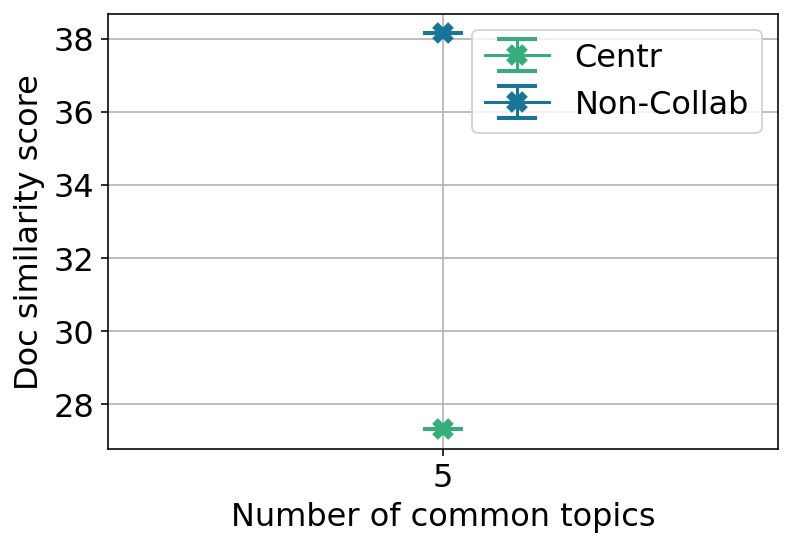

In [34]:
(_, caps, _) = plt.errorbar(frozen_topics_list,
                            sim_thetas_centralized_mean,
                            yerr=sim_thetas_centralized_std,
                            label="Centr",
                            marker="x", markersize=8, mew=4, color = "#36AE7C", capsize=10)
(_, caps2, _) = plt.errorbar(frozen_topics_list,
                             sim_thetas_non_colab_mean,
                             yerr=sim_thetas_non_colab_std,
                             label="Non-Collab",
                             marker="x", markersize=8, mew=4, color = "#187498", capsize=10)

for cap in caps:
    cap.set_markeredgewidth(2)
for cap in caps2:
    cap.set_markeredgewidth(2)

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
plt.xticks(frozen_topics_list, [5,10,15,40])
plt.legend(loc="best")
plt.show()

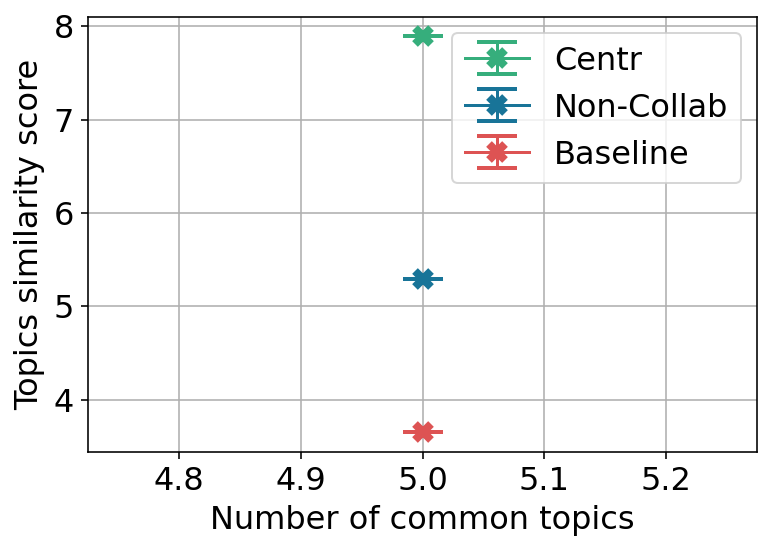

In [35]:
(_, caps, _) = plt.errorbar(frozen_topics_list,
                            sim_betas_centralized_mean,
                            yerr = sim_betas_centralized_std,
                            label="Centr",
                            marker="x", markersize=8, mew=4, color = "#36AE7C", capsize=10)
(_, caps2, _) = plt.errorbar(frozen_topics_list,
                            sim_betas_non_colab_mean,
                            yerr=sim_betas_non_colab_std,
                            label="Non-Collab", 
                            marker="x", markersize=8, mew=4, color = "#187498", capsize=10)    
(_, caps3, _) = plt.errorbar(frozen_topics_list,
                            sim_betas_baseline_mean,
                            yerr = sim_betas_baseline_std,
                            label="Baseline",
                            marker="x", markersize=8, mew=4, color = "#DD5353", capsize=10) 
   
for cap in caps:
    cap.set_markeredgewidth(2)
for cap in caps2:
    cap.set_markeredgewidth(2)
for cap in caps3:
    cap.set_markeredgewidth(2)

plt.xlabel('Number of common topics', fontsize=16)
plt.ylabel('Topics similarity score', fontsize=16)
plt.legend(loc="best")
plt.grid()
plt.show()

In [65]:
frozen_topics_list = [5,10,15,40]
eta_list = [1e-2, 0.02]
#eta_list = [1e-2, 0.02, 0.03, 0.04, 0.08, 1]

sim_betas_centralized_mean = []
sim_betas_centralized_std = []

sim_thetas_centralized_mean = []
sim_thetas_centralized_std = []

sim_betas_non_colab_mean = []
sim_betas_non_colab_std = []

sim_thetas_non_colab_mean = []
sim_thetas_non_colab_std = []

sim_thetas_baseline_mean = []
sim_thetas_baseline_std = []

sim_betas_baseline_mean = []
sim_betas_baseline_std = []

for eta in eta_list:
    print("Executing for eta equals to ", str(eta))
    
    # Aquí se guardan los resultados para cada una de las 5 iter
    sim_betas_centralized_iters = []
    sim_thetas_centralized_iters = []
    sim_betas_non_colab_iters = []
    sim_thetas_non_colab_iters = []
    #sim_thetas_non_colab_std_iters = []
    #sim_betas_non_colab_std_iters = []
    sim_thetas_baseline_iters = []
    sim_betas_baseline_iters = []
    
    for iter_ in range(5):
        print(f"Executing for iteration {str(iter_)}")
    
        tm_settings["beta"] = eta

        # Recalculate centralized settings
        frozen_topics = frozen_topics_list[1]
        prior_frozen = frozen_topics * [alpha]
        own_topics = int((n_topics-frozen_topics)/n_nodes)
        prior_nofrozen = own_topics * [alpha] + (n_topics-frozen_topics-own_topics) * [alpha/10000]
        
        print(len(prior_frozen))
        print(len(prior_nofrozen))

        centralized_settings = {
            "n_nodes": n_nodes,
            "frozen_topics": frozen_topics,
            "prior_frozen": prior_frozen,
            "own_topics": own_topics,
            "prior_nofrozen": prior_nofrozen
        }

        # Generate documents
        topic_vectors, doc_topics_all, documents_all = generateSynthetic(False, True, **tm_settings, **centralized_settings)

        # Generate inference corpus and its docs_topics
        inf = [doc for docs_node in documents_all for doc in docs_node[n_docs:(n_docs+n_docs_global_inf)]]
        print("Length of the inference corpus ", str(len(inf)))

        for i in range(len(doc_topics_all)):
            if i == 0:
                inf_doc_topics = doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)]
            else:
                inf_doc_topics = np.concatenate((inf_doc_topics,doc_topics_all[i][n_docs:(n_docs+n_docs_global_inf)])) 
        print("Shape of inf_doc_topics", str(inf_doc_topics.shape))

        # Generate a randomly generate topic vector matrix to compare the alignment with the true one

        #Here we compare alignment of the topic_vector matrix with itself and with another randomly generated matrix
        topic_vectors2 = np.random.dirichlet(vocab_size*[eta], n_topics)
        betas_bas = eval_betas(topic_vectors2, topic_vectors)
        #sim_betas_bas.append(betas_bas)
        sim_betas_baseline_iters.append(betas_bas)

        ########################
        # Centralized training #
        ########################
        print("CENTRALIZED")
        # Define corpus
        corpus = [doc for docs_node in documents_all for doc in docs_node[0:n_docs]]
        print("Size of centralized corpus ", str(len(corpus)))

        # Train model 
        modelname = "prod_centralized"
        modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

        # Get betas
        betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
        betas = softmax(betas, axis=1)
        all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
        betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                model=avitm,
                                                model_type="avitm",
                                                ntopics=n_topics,
                                                id2token=id2token,
                                                all_words=all_words)

        # Get thetas
        #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))[0:n_docs,:]
        #thetas_theoretical = doc_topics_all[0][0:n_docs]

        # Eval betas and thetas
        betas_31 = eval_betas(betas, topic_vectors)
        #thetas_31 = eval_thetas(thetas_theoretical, thetas, len(thetas))
        #sim_betas_centralized.append(betas_31)
        sim_betas_centralized_iters.append(betas_31)


        # Inference
        # Get inferred thetas
        docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
        val_bow = cv.transform(docs_val_conv)
        val_bow = val_bow.toarray()
        val_data = BOWDataset(val_bow, idx2token)

        thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))
        thetas_theoretical = inf_doc_topics

        # Eval thetas
        thetas_312 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
        #sim_thetas_centralized.append(thetas_312)
        sim_thetas_centralized_iters.append(thetas_312)

        #############################
        # Non-colaborative training #
        #############################
        betas_nodes = []
        thetas_nodes = []
        for node in range(n_nodes):
            print("NON-COLLABORATIVE of node ", str(node))
            # Define corpus
            corpus = documents_all[node][0:n_docs]
            print("Size of non-collaborative corpus ", str(len(corpus)))

            # Train model 
            modelname = "prodlda_node"
            modeldir, avitm, cv, id2token, idx2token = train_avitm(modelname, modelsdir, corpus)

            # Get betas
            betas = avitm.get_topic_word_mat()#avitm.get_topic_word_distribution()
            betas = softmax(betas, axis=1)
            all_words = ['wd'+str(word) for word in np.arange(vocab_size+1) if word > 0]
            betas = convert_topic_word_to_init_size(vocab_size=vocab_size,
                                                    model=avitm,
                                                    model_type="avitm",
                                                    ntopics=n_topics,
                                                    id2token=id2token,
                                                    all_words=all_words)

            # Get thetas
            #thetas = np.asarray(avitm.get_doc_topic_distribution(avitm.train_data))
            #thetas_theoretical = doc_topics_all[0][0:n_docs]


            # Eval betas and thetas
            betas_32 = eval_betas(betas, topic_vectors)
            betas_nodes.append(betas_32)

            #thetas_32 = eval_thetas(thetas_theoretical, thetas, len(thetas))

            # Inference
            # Get inferred thetas
            docs_val_conv = [" ".join(inf[i]) for i in np.arange(len(inf))]
            val_bow = cv.transform(docs_val_conv)
            val_bow = val_bow.toarray()
            val_data = BOWDataset(val_bow, idx2token)

            thetas_inf = np.asarray(avitm.get_thetas(val_data))#np.asarray(avitm.get_doc_topic_distribution(val_data))

            thetas_theoretical = inf_doc_topics

            # Eval thetas
            thetas_322 = eval_thetas(thetas_theoretical, thetas_inf, len(thetas_inf))
            thetas_nodes.append(thetas_322)

        avg1 = sum(betas_nodes)/n_nodes
        avg2 = sum(thetas_nodes)/n_nodes
        #std1 = np.std(betas_nodes)
        #std2 = np.std(thetas_nodes)

        #sim_betas_non_colab.append(avg1)
        sim_betas_non_colab_iters.append(avg1)
        #sim_betas_non_colab_std.append(std1)
        #sim_thetas_non_colab.append(avg2)
        sim_thetas_non_colab_iters.append(avg2)

        #sim_thetas_non_colab_std.append(std2)
        print("Nodes averages betas and thetas inf: ", str(avg1), str(avg2))
        #print("Nodes averages betas and thetas inf std: ", str(std1), str(std2))
    
    sim_betas_centralized_mean.append(np.mean(sim_betas_centralized_iters))
    sim_betas_centralized_std.append(np.std(sim_betas_centralized_iters))

    sim_thetas_centralized_mean.append(np.mean(sim_thetas_centralized_iters))
    sim_thetas_centralized_std.append(np.std(sim_thetas_centralized_iters))

    sim_betas_non_colab_mean.append(np.mean(sim_betas_non_colab_iters))
    sim_betas_non_colab_std.append(np.std(sim_betas_non_colab_iters))

    sim_thetas_non_colab_mean.append(np.mean(sim_thetas_non_colab_iters))
    sim_thetas_non_colab_std.append(np.std(sim_thetas_non_colab_iters))

    #sim_thetas_baseline_mean.append(np.mean(sim_thetas_baseline_iters))
    #sim_thetas_baseline_std.append(np.std(sim_thetas_baseline_iters))
    
    sim_betas_baseline_mean.append(np.mean(sim_betas_baseline_iters))
    sim_betas_baseline_std.append(np.std(sim_betas_baseline_iters))
    

Executing for eta equals to  0.01
Executing for iteration 0
10
40
Generating document words for node  0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 46.57it/s]


Generating document words for node  1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 44.83it/s]


Generating document words for node  2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 44.74it/s]


Generating document words for node  3


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 43.57it/s]


Generating document words for node  4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:02<00:00, 47.88it/s]


Length of the inference corpus  50
Shape of inf_doc_topics (50, 50)
Tópicos (equivalentes) evaluados correctamente:
3.5611628662284094
CENTRALIZED
Size of centralized corpus  500
-- -- Creating backup of existing model in /export/usuarios_ml4ds/lbartolome/data/project_folder/TMmodels/Federated_test/prod_centralized_old
Epoch: [1/100]	Samples: [375/37500]	Train Loss: 1780.97725	Time: 0:00:00.037559
Epoch: [1/100]	Samples: [125/12500]	Validation Loss: 1615.3745625	Time: 0:00:00.005973
Epoch: [2/100]	Samples: [750/37500]	Train Loss: 1773.4857916666667	Time: 0:00:00.052317
Epoch: [2/100]	Samples: [125/12500]	Validation Loss: 1615.0958125	Time: 0:00:00.009331
Epoch: [3/100]	Samples: [1125/37500]	Train Loss: 1760.1965416666667	Time: 0:00:00.052419
Epoch: [3/100]	Samples: [125/12500]	Validation Loss: 1616.446125	Time: 0:00:00.009600
Epoch: [4/100]	Samples: [1500/37500]	Train Loss: 1739.9708541666666	Time: 0:00:00.044910
Epoch: [4/100]	Samples: [125/12500]	Validation Loss: 1619.746625	Time: 0:

Epoch: [1/100]	Samples: [75/7500]	Train Loss: 1633.2425260416667	Time: 0:00:00.012304
Epoch: [1/100]	Samples: [25/2500]	Validation Loss: 1559.7984375	Time: 0:00:00.003668
Epoch: [2/100]	Samples: [150/7500]	Train Loss: 1635.0472395833333	Time: 0:00:00.020346
Epoch: [2/100]	Samples: [25/2500]	Validation Loss: 1559.12171875	Time: 0:00:00.002912
Epoch: [3/100]	Samples: [225/7500]	Train Loss: 1620.9304166666666	Time: 0:00:00.022208
Epoch: [3/100]	Samples: [25/2500]	Validation Loss: 1558.52015625	Time: 0:00:00.003075
Epoch: [4/100]	Samples: [300/7500]	Train Loss: 1625.90203125	Time: 0:00:00.016061
Epoch: [4/100]	Samples: [25/2500]	Validation Loss: 1557.845625	Time: 0:00:00.002897
Epoch: [5/100]	Samples: [375/7500]	Train Loss: 1626.3070572916668	Time: 0:00:00.015983
Epoch: [5/100]	Samples: [25/2500]	Validation Loss: 1557.8821875	Time: 0:00:00.003604
Epoch: [6/100]	Samples: [450/7500]	Train Loss: 1609.5988020833333	Time: 0:00:00.013707
Epoch: [6/100]	Samples: [25/2500]	Validation Loss: 1557.57

In [67]:
df = pd.DataFrame(list(zip(eta_list,
                           sim_betas_centralized_mean,
                           sim_betas_centralized_std,
                           sim_thetas_centralized_mean,
                           sim_thetas_centralized_std,
                           sim_betas_non_colab_mean,
                           sim_betas_non_colab_std,
                           sim_thetas_non_colab_mean,
                           sim_thetas_non_colab_std,
                           #sim_thetas_baseline_mean,
                           #sim_thetas_baseline_std,
                           sim_betas_baseline_mean,
                           sim_betas_baseline_std)),
               columns =['etas', 
                         'sim_betas_centralized_mean','sim_betas_centralized_std',
                         'sim_thetas_centralized_mean','sim_thetas_centralized_std',
                         'sim_betas_non_colab_mean', 'sim_betas_non_colab_std',
                         'sim_thetas_non_colab_mean', 'sim_thetas_non_colab_std',
                         #'sim_thetas_baseline_mean', 'sim_thetas_baseline_std',
                         'sim_betas_baseline_mean', 'sim_betas_baseline_std'
                        ])
df

,etas,sim_betas_centralized_mean,sim_betas_centralized_std,sim_thetas_centralized_mean,sim_thetas_centralized_std,sim_betas_non_colab_mean,sim_betas_non_colab_std,sim_thetas_non_colab_mean,sim_thetas_non_colab_std,sim_betas_baseline_mean,sim_betas_baseline_std
0,0.01,7.799814,0.0,27.838596,0.0,5.473957,0.0,36.42933,0.0,3.561163,0.0


In [ ]:
import pickle

with open('/export/usuarios_ml4ds/lbartolome/results_experiments_last_hour/results_etas.pickle', 'wb') as handle:
    pickle.dump(df, handle)

In [ ]:
plt.plot(eta_list, sim_thetas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")
(_, caps, _) = plt.errorbar(eta_list, sim_thetas_non_colab, yerr=sim_thetas_non_colab_std, label="Non-Collab", marker="x", markersize=8, mew=4, 
                            color = "#187498", capsize=10)
for cap in caps:
    cap.set_markeredgewidth(2)
    
plt.legend(loc="best")
plt.xscale('log')

plt.xlabel(r'$\eta$', fontsize=16)
plt.ylabel('Doc similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()

In [ ]:
print(sim_betas_centralized)
print(sim_betas_non_colab)

In [ ]:
plt.plot(eta_list, sim_betas_centralized, label="Centr", marker="x", markersize=8, mew=4, color = "#36AE7C")

(_, caps, _) = plt.errorbar(eta_list, sim_betas_non_colab, yerr =sim_betas_non_colab_std, label="Non-Collab", marker="x", markersize=8, mew=4,
                            color = "#187498", capsize=10)
for cap in caps:
    cap.set_markeredgewidth(2)
    
plt.plot(eta_list, sim_betas_bas, label="Baseline", marker="x", markersize=8, mew=4, color = "#DD5353")
#semilogx
plt.legend(loc="best")

plt.xlabel(r'$\eta$', fontsize=16)
plt.xscale('log')
plt.ylabel('Topics similarity score', fontsize=16)
#plt.xticks(eta_list, [1e-2, 0.02, 0.03, 0.04, 0.08, 1])
plt.grid()
plt.show()